In [1]:
install.packages("readxl")
install.packages("vars")
install.packages("tseries")
install.packages("lmtest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘strucchange’, ‘urca’, ‘lmtest’, ‘sandwich’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(readxl)
library(vars)
library(tseries)
library(lmtest)
library(data.table)


Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



### SPX

           Date       GDP   PCEPI GDP_deflated    M1SL    M2SL 1Y Treasury
         <Date>     <num>   <num>        <num>   <num>   <num>       <num>
  1: 1994-03-01  7149.664  65.937     108.4317  1140.1  3480.1        3.34
  2: 1994-04-01  7186.466  66.015     108.8611  1141.1  3481.3        3.56
  3: 1994-05-01  7290.067  66.111     110.2701  1143.3  3490.8        4.01
  4: 1994-06-01  7264.260  66.272     109.6128  1145.2  3479.5        4.25
  5: 1994-07-01  7299.325  66.481     109.7957  1150.7  3488.2        4.26
 ---                                                                      
355: 2023-09-01 27824.678 121.267     229.4497 18150.4 20710.1        5.33
356: 2023-10-01 27732.565 121.309     228.6109 18071.5 20698.7        5.33
357: 2023-11-01 27948.828 121.296     230.4184 18014.7 20724.9        5.33
358: 2023-12-01 28189.240 121.448     232.1095 18022.0 20786.1        5.33
359: 2024-01-01 28107.311 121.906     230.5654 17987.0 20790.2        5.33
     10Y Treasury S5TELS 

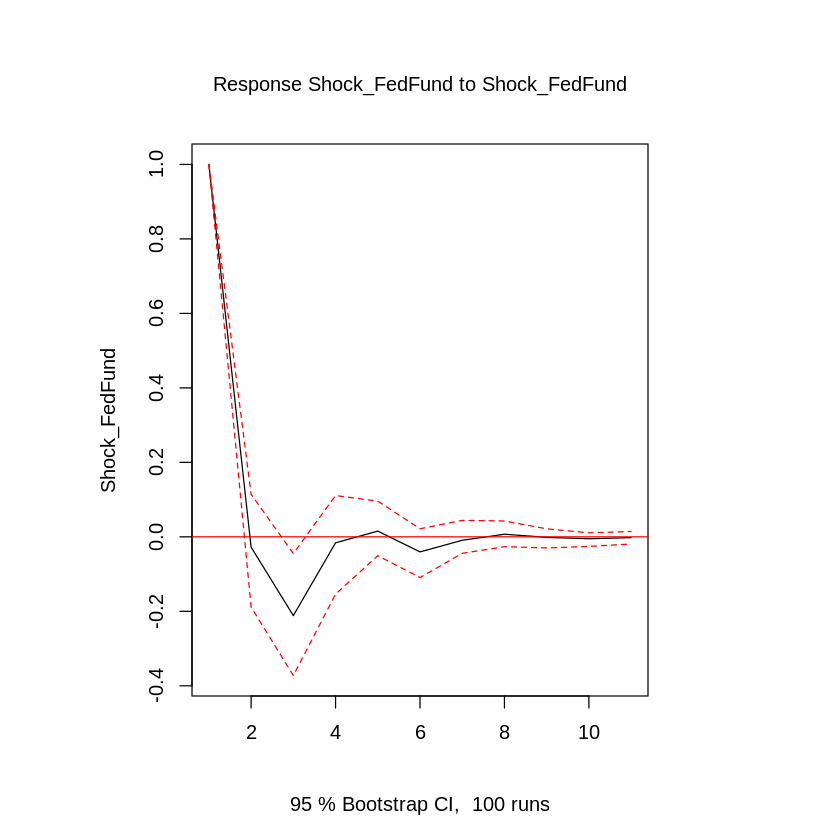

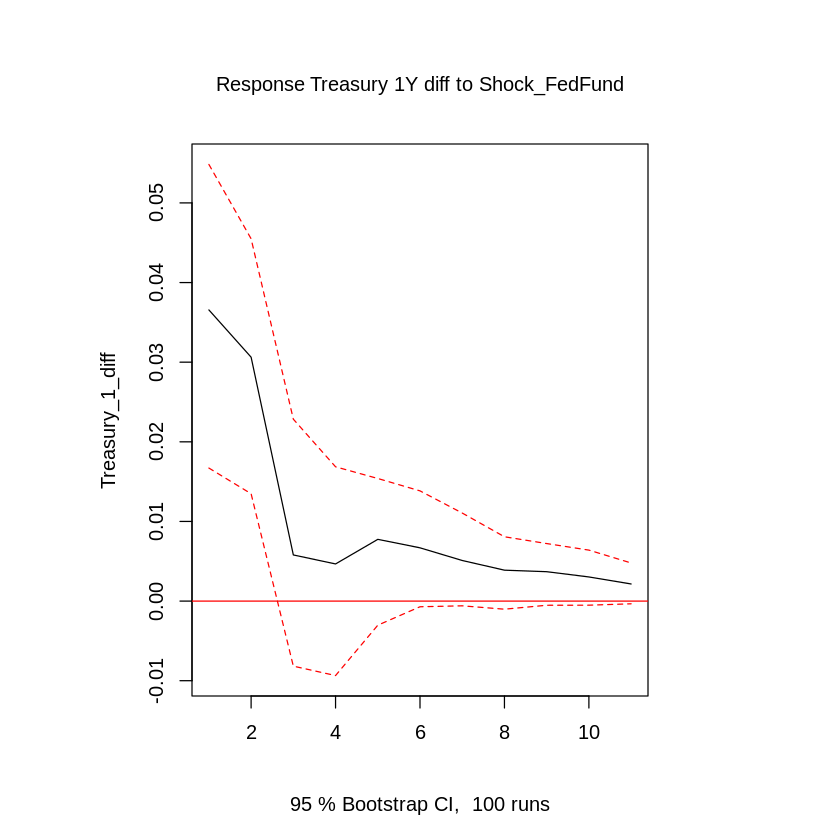

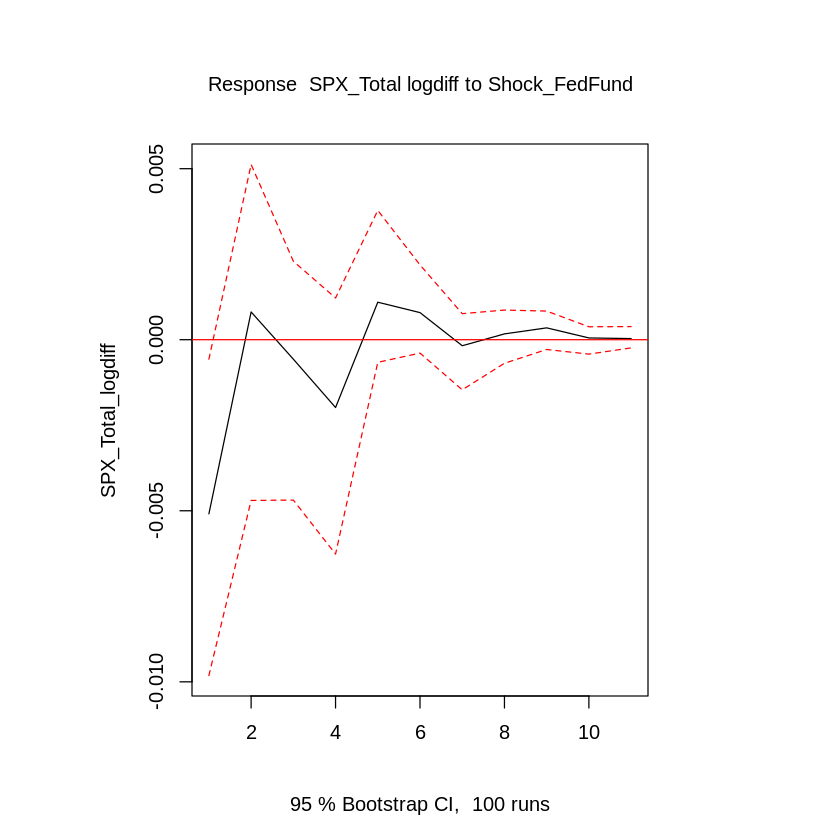

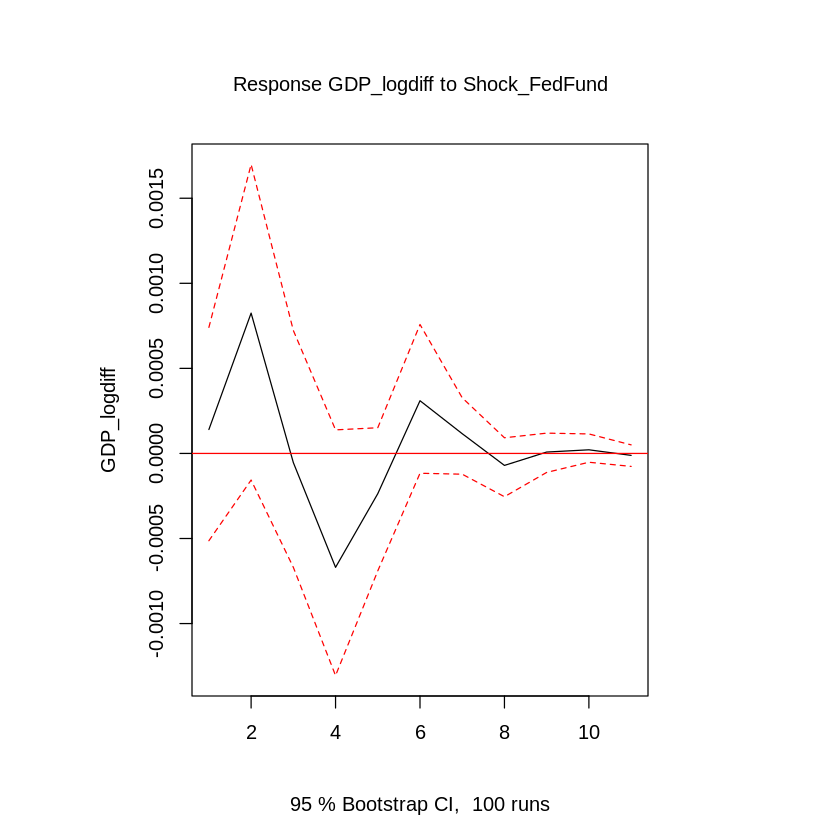

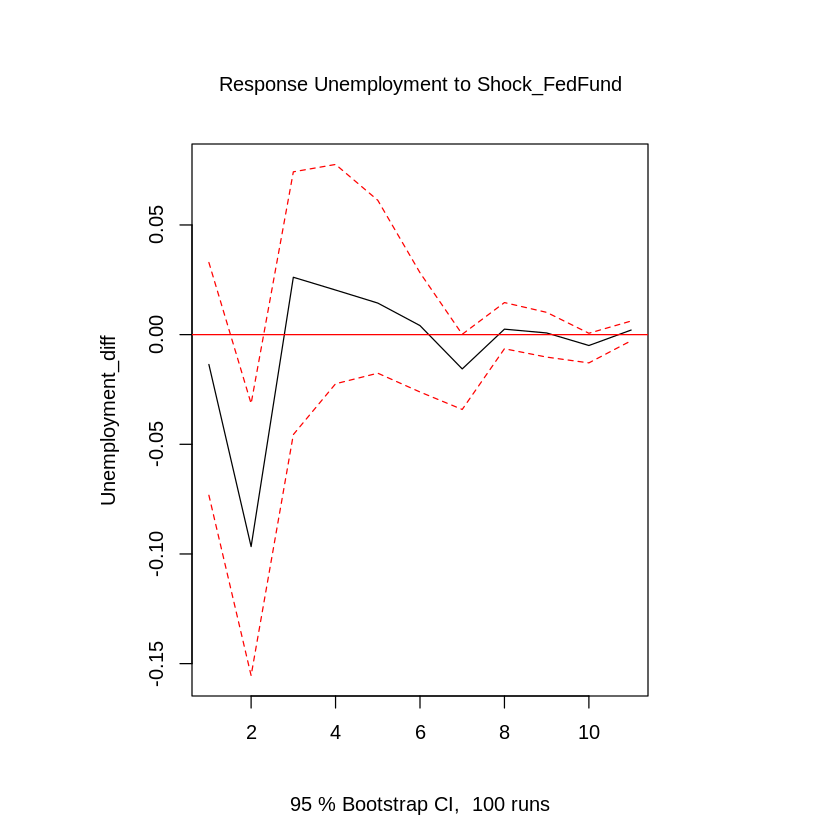

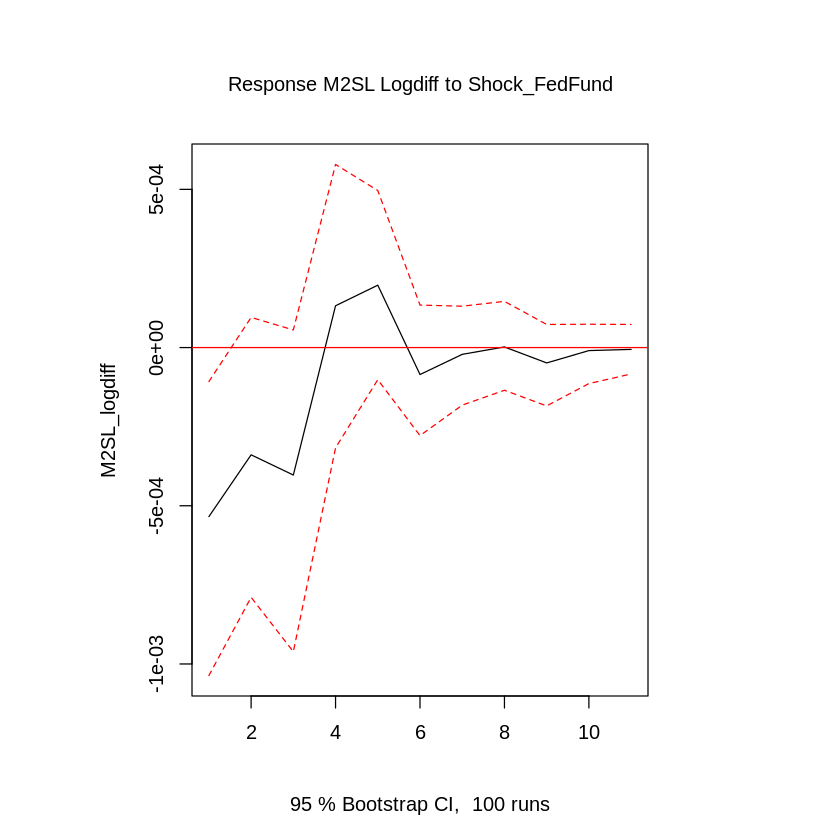

In [19]:
suppressWarnings({

  # Read the specific sheet from the Excel file
  sheet_name <- "Condensed (final) data"  # Replace with the actual sheet name
  df <- read_excel('Source Data.xlsx', sheet = sheet_name)

  setDT(df)

  df[, Date := as.Date(Date)]
  df <- df[df$Date > as.Date("1994-02-01")]
  #print(df)

  print(df)
  # Apply log then differencing for GDP, PCEPI, M2SL, and SPX Total
  GDP_logdiff <- diff(log(df$GDP_deflated))
  PCEPI_logdiff <- diff(log(df$PCEPI))
  M2SL_logdiff <- diff(log(df$M2SL))
  SPX_Total_logdiff <- diff(log(df$`SPX Total`))

  # Apply differencing for 1Y Treasury and FEDFUNDS
  Treasury_1_diff <- diff(df$`1Y Treasury`)
  FEDFUNDS_diff <- diff(df$FEDFUNDS)
  Unemployment_diff <- diff(df$Unemployment)


  # Include other variables, skipping the first row to match the reduced length
  Unemployment <- df$Unemployment[-1]
  Shock_FedFund <- df$`Futures Shock`[-1]
  FEDFUNDS <- df$FEDFUNDS[-1]
  Treasury_10 <- df$`10Y Treasury`[-1]
  Credit_Spread <- df$`Credit Spread`[-1]
  Dates <- df$Date[-1]


  # Create a new data frame with the transformed variables
  df_diff <- data.frame(
    Date = Dates,
    GDP_logdiff = GDP_logdiff,
    M2SL_logdiff = M2SL_logdiff,
    PCEPI_logdiff = PCEPI_logdiff,
    SPX_Total_logdiff = SPX_Total_logdiff,
    Treasury_1_diff = Treasury_1_diff,
    Unemployment = Unemployment,
    Shock_FedFund = Shock_FedFund,
    Credit_Spread = Credit_Spread,
    Unemployment_diff = Unemployment_diff
    )

  df_diff$dummy_outlier <- ifelse((df_diff$Date == "2008-09-01" | df_diff$Date == "2008-10-01" | df_diff$Date == "2009-01-01" | df_diff$Date == "2009-02-01" | df_diff$Date == "2020-02-01" | df_diff$Date == "2020-03-01" | df_diff$Date == "2020-04-01"), 1, 0)


  # Select the columns needed for the VAR model
  #var_data <- df_diff[, c('FEDFUNDS', 'GDP_logdiff', 'PCEPI_logdiff', 'M2SL_logdiff','SPX_Total_logdiff', 'Unemployment')]
  #var_data <- df_diff[, c('Shock_FedFund', 'FEDFUNDS_diff', 'SPX_Total_logdiff', 'M2SL_logdiff', 'GDP_logdiff', 'PCEPI_logdiff', 'Unemployment')]
  #var_data <- df_diff[, c('Shock_FedFund', 'SPX_Total_logdiff')]

  var_data <- df_diff[, c('Shock_FedFund', 'Treasury_1_diff', 'SPX_Total_logdiff', 'GDP_logdiff', 'Unemployment_diff', 'M2SL_logdiff')]

  var_data <- na.omit(var_data)
  df_diff <- na.omit(df_diff)


  # Determine optimal lag length
  lag_selection <- VARselect(var_data, lag.max = 12, type = "c")
  optimal_lags <- lag_selection$selection["AIC(n)"]
  print(optimal_lags)

  var_model <- VAR(var_data, p = optimal_lags, type = "c", exogen = df_diff$dummy_outlier)

  print(summary(var_model))

  # Number of variables in var_data
  n_vars <- ncol(var_data)

  # Create a lower triangular matrix of NA values
  A_matrix <- matrix(NA, nrow = n_vars, ncol = n_vars)

  # Set the diagonal elements to 1 (assuming exogeneity in the ordering of var_data)
  diag(A_matrix) <- 1
  A_matrix[upper.tri(A_matrix)] <- 0

  print(A_matrix)

  # Fit the SVAR model
  svar_model <- SVAR(var_model, Amat = A_matrix)


  # Impulse Response Functions
  irf_results1 <- irf(svar_model, impulse = "Shock_FedFund", response = "Shock_FedFund", n.ahead = 10)
  irf_results2 <- irf(var_model, impulse = "Shock_FedFund", response = "Treasury_1_diff", n.ahead = 10)
  irf_results3 <- irf(var_model, impulse = "Shock_FedFund", response = "SPX_Total_logdiff", n.ahead = 10)
  irf_results4 <- irf(var_model, impulse = "Shock_FedFund", response = "GDP_logdiff", n.ahead = 10)
  irf_results5 <- irf(var_model, impulse = "Shock_FedFund", response = "Unemployment_diff", n.ahead = 10)
  irf_results6 <- irf(var_model, impulse = "Shock_FedFund", response = "M2SL_logdiff", n.ahead = 10)

  # Plotting setup for multiple plots
  par(mfrow=c(2,3))

  plot(irf_results1, main = "Response Shock_FedFund to Shock_FedFund")
  plot(irf_results2, main = "Response Treasury 1Y diff to Shock_FedFund")
  plot(irf_results3, main = "Response  SPX_Total logdiff to Shock_FedFund")
  plot(irf_results4, main = "Response GDP_logdiff to Shock_FedFund")
  plot(irf_results5, main = "Response Unemployment to Shock_FedFund")
  plot(irf_results6, main = "Response M2SL Logdiff to Shock_FedFund")

  # Reset plot layout
  #par(mfrow=c(1,1))

})

In [20]:
# Apply ADF test
apply(var_data, 2, function(x) {
  test <- adf.test(x, alternative = "stationary")
  print(test)
})

Warning message in adf.test(x, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -5.627, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(x, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -4.2083, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(x, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -5.5844, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(x, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -7.678, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(x, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -7.8039, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(x, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -4.4233, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



$Shock_FedFund

	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -5.627, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


$Treasury_1_diff

	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -4.2083, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


$SPX_Total_logdiff

	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -5.5844, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


$GDP_logdiff

	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -7.678, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


$Unemployment_diff

	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -7.8039, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


$M2SL_logdiff

	Augmented Dickey-Fuller Test

data:  x
Dickey-Fuller = -4.4233, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



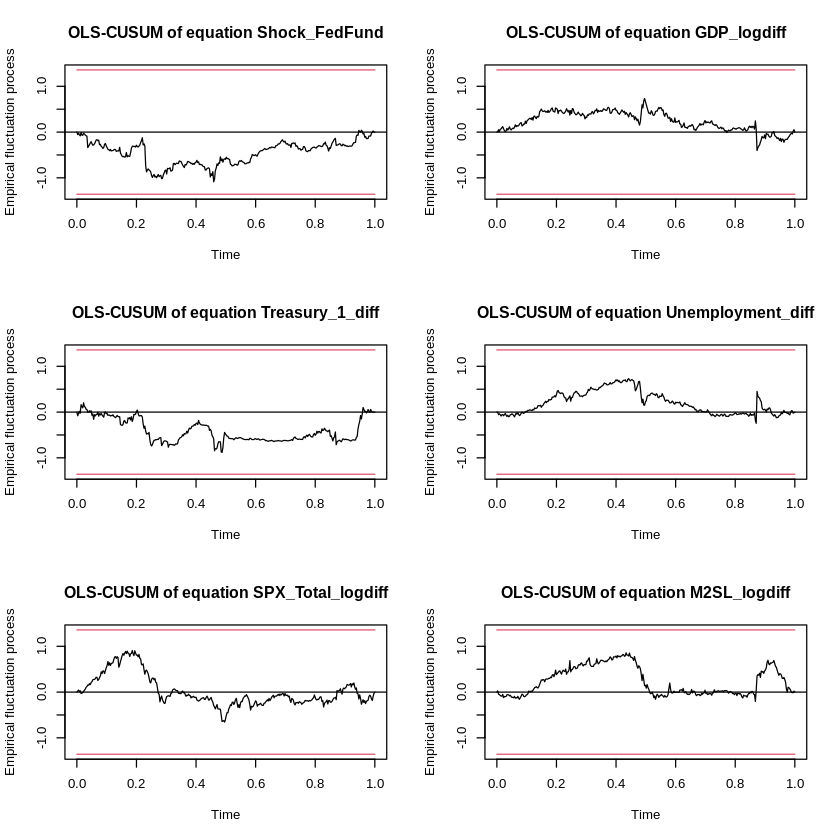

In [16]:
var.stabil <- stability(var_model, type = "OLS-CUSUM")
plot(var.stabil)


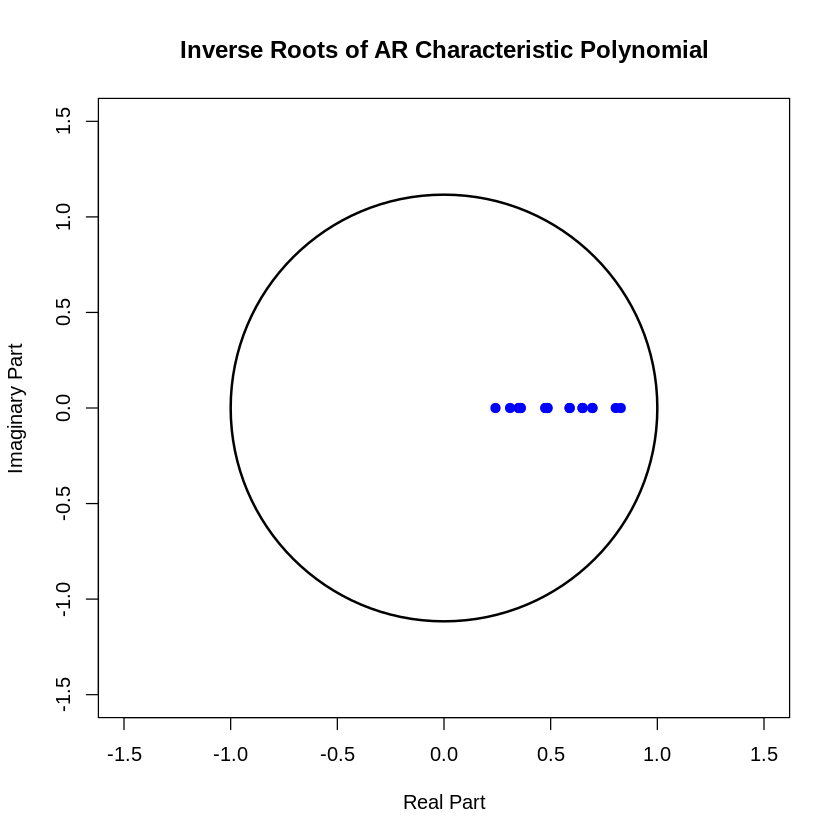

In [21]:
# Get the eigenvalues (roots) of the VAR model
eigenvalues <- roots(var_model)  # var_model$A is the companion matrix of the VAR model
# Plotting
plot(0, 0, type = "n", xlim = c(-1.5, 1.5), ylim = c(-1.5, 1.5), xlab = "Real Part", ylab = "Imaginary Part", main = "Inverse Roots of AR Characteristic Polynomial")
symbols(0, 0, circles = 1, inches = FALSE, add = TRUE, lwd = 2)
points(Re(eigenvalues), Im(eigenvalues), pch = 19, col = "blue")


In [6]:
normality.test(var_model, multivariate.only = TRUE)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 16623, df = 12, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 731.32, df = 6, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 15891, df = 6, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 16623, df = 12, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 731.32, df = 6, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 15891, df = 6, p-value < 2.2e-16




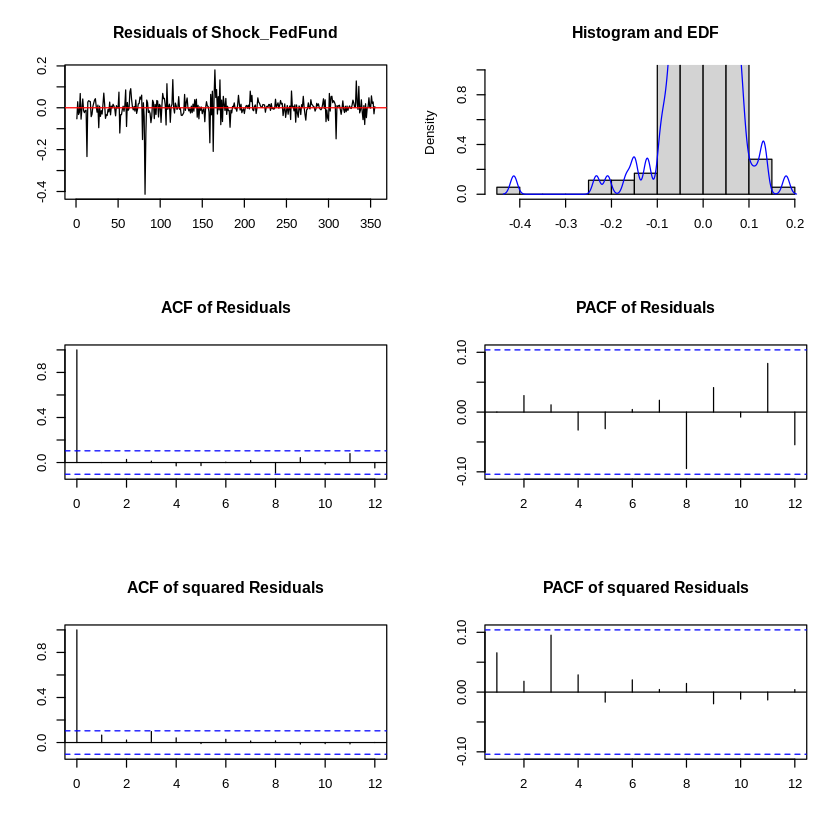

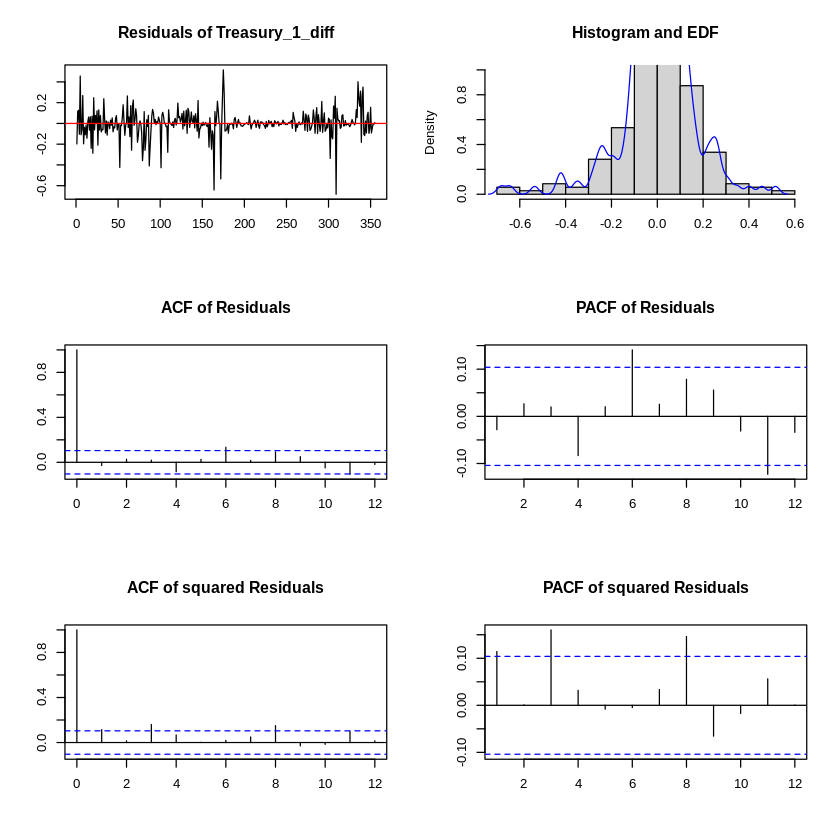

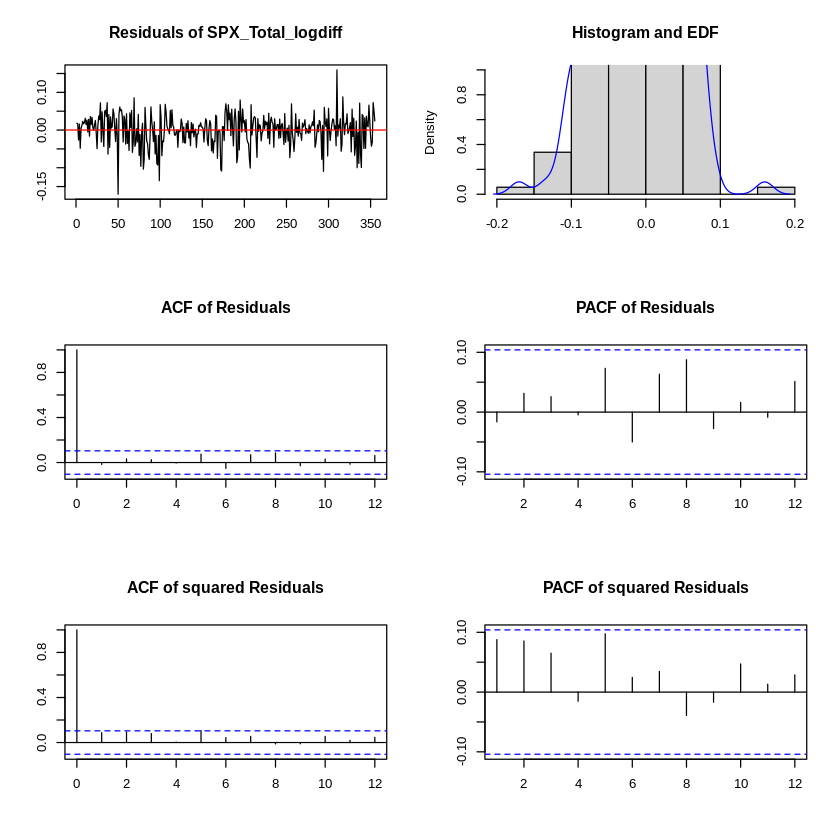

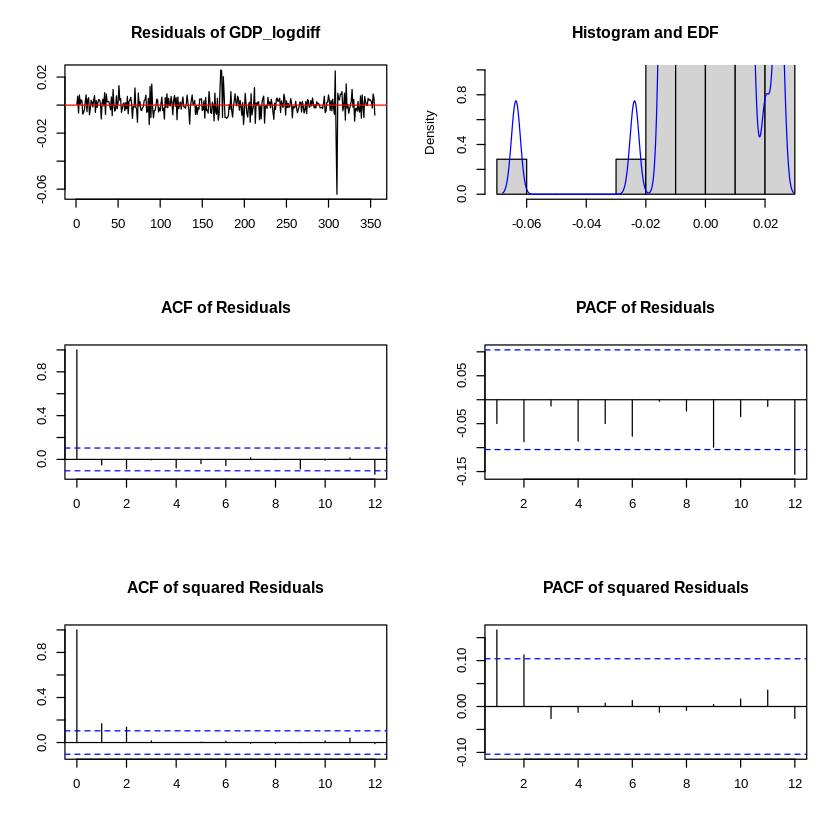

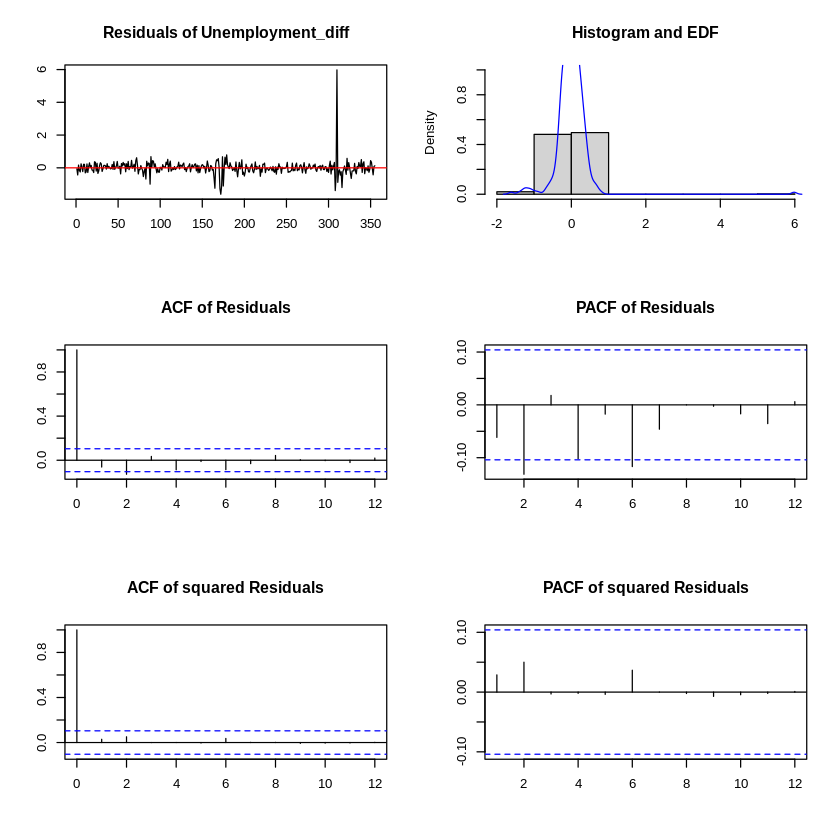


	Breusch-Godfrey LM test

data:  Residuals of VAR object var_model
Chi-squared = 388.71, df = 180, p-value < 2.2e-16

$serial

	Breusch-Godfrey LM test

data:  Residuals of VAR object var_model
Chi-squared = 388.71, df = 180, p-value < 2.2e-16



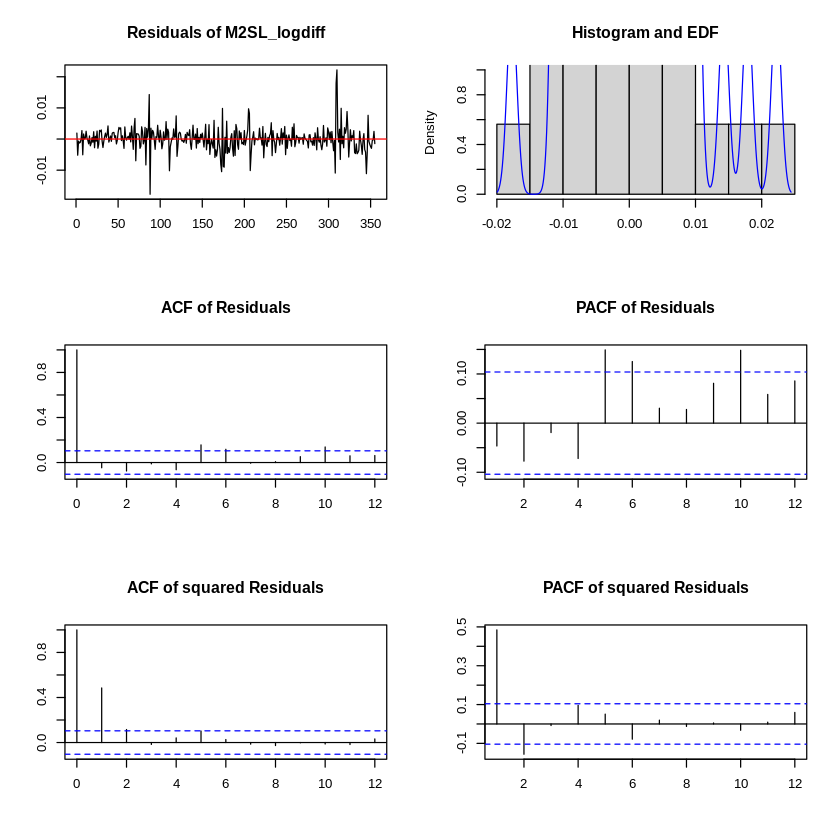

In [18]:
serialtest <- serial.test(var_model)
plot(serialtest)
serial.test(var_model, type = "BG")


In [15]:
serial_test_bj <- serial.test(var_model, type = "BG")
print(serial_test_bj)


	Breusch-Godfrey LM test

data:  Residuals of VAR object var_model
Chi-squared = 388.71, df = 180, p-value < 2.2e-16



$serial

	Breusch-Godfrey LM test

data:  Residuals of VAR object var_model
Chi-squared = 388.71, df = 180, p-value < 2.2e-16



In [ ]:
# Breusch-Pagan test
bptest(residuals(var_model) ~ fitted(var_model))



	studentized Breusch-Pagan test

data:  residuals(var_model) ~ fitted(var_model)
BP = 154.62, df = 6, p-value < 2.2e-16


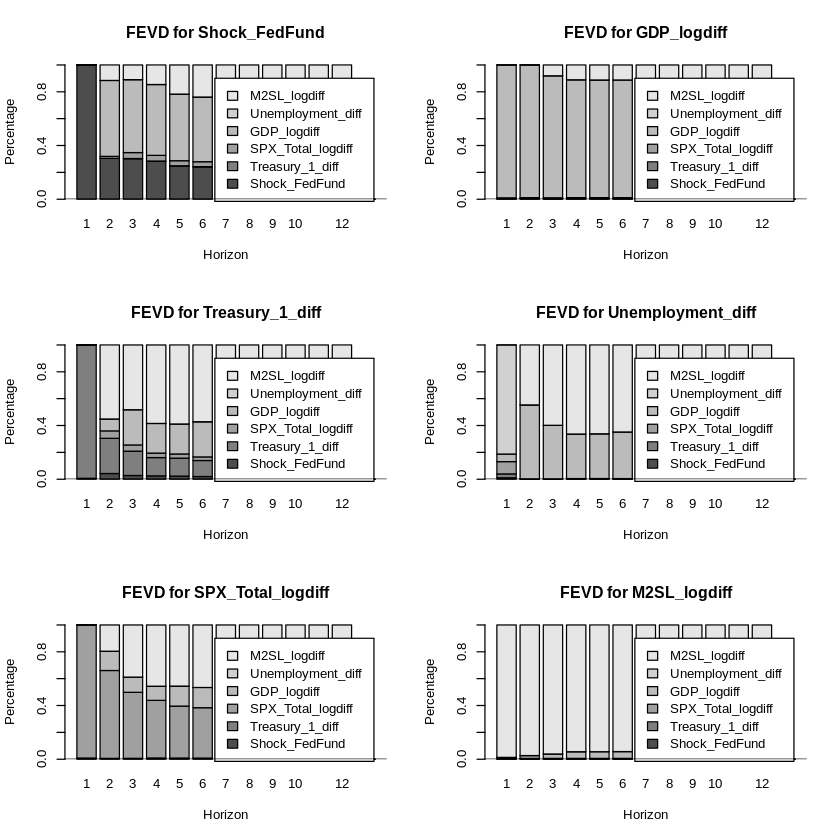

In [9]:
# FEVD
var.fevd <- fevd(svar_model, n.ahead = 12)
plot(var.fevd)


In [22]:
causality(var_model, cause = NULL, vcov.=NULL, boot=FALSE, boot.runs=100)


Warning message in causality(var_model, cause = NULL, vcov. = NULL, boot = FALSE, :
“
Argument 'cause' has not been specified;
using first variable in 'x$y' (Shock_FedFund) as cause variable.
”


$Granger

	Granger causality H0: Shock_FedFund do not Granger-cause
	Treasury_1_diff SPX_Total_logdiff GDP_logdiff Unemployment_diff
	M2SL_logdiff

data:  VAR object var_model
F-Test = 1.5951, df1 = 15, df2 = 2010, p-value = 0.06748


$Instant

	H0: No instantaneous causality between: Shock_FedFund and
	Treasury_1_diff SPX_Total_logdiff GDP_logdiff Unemployment_diff
	M2SL_logdiff

data:  VAR object var_model
Chi-squared = 32.122, df = 5, p-value = 5.62e-06

